# LUNA16 Pre-processing Script

### Summary: 
This is the [**LU**ng **N**odule **A**nalysis](https://luna16.grand-challenge.org) (LUNA16) script for reading in the CT scans and extracting image patches around the candidate regions of interest (ROI). 

### Problem overview:

[Pulmonary nodules](https://my.clevelandclinic.org/health/articles/pulmonary-nodules) are round or oval-shaped regions in the lungs that appear on an Xray and CT scan.  By definition they are smaller than 30 mm in diameter. (Anything larger is easily located by the radiologist and usually more signficant.) Most nodules are less than 10 mm (the size of a cherry). 

Nodules are highly common. About 0.2% of all Xrays and almost **half** of all CTs show at least one nodule. Over 90% of the nodules less than 20 mm are benign. For the 10% that are malignant, the tumor is small enough that early diagnosis and treatment is highly effective. 

Ideally we'd like to rapidly identify only those nodules which need further scrutiny by a physician.

The challenge is two-fold:
1. Automate locating potential nodules (candidates) in a CT
2. Automate classifying candidates as either (1) true nodules or (0) non-nodules.

In [1]:
import SimpleITK as sitk
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import ntpath
%matplotlib inline

## Data

The data comes from the publicly-available [LIDC-IDRI](https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI) website and has a [Creative Commons Attribution 3.0 Unported](https://creativecommons.org/licenses/by/3.0/) license.

I downloaded and extracted the data onto DiskStation. On rain1.sd.nervana.ai it is stored as /mnt/data/tonyr/dicom/LUNA16 [disk size ~ 112 GB]. The data is separated into 10 folds (subset0 through subset9). The challenge website asks us to perform a 10-fold cross-validation. So we need to train on 9 of the datasets and test one the remaining one. Repeat that for all 10 folds and report the average performance.

This are some sample ROI from the [original paper](https://www.ncbi.nlm.nih.gov/pubmed/21452728):
![image](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3041807/bin/MPHYA6-000038-000915_1-g003.jpg)

In [2]:
# To get the data:
# wget https://www.dropbox.com/sh/mtip9dx6zt9nb3z/AAAs2wbJxbNM44-uafZyoMVca/subset5.zip
# The files are 7-zipped. Regular linux unzip won't work to uncompress them. Use 7za instead.
# 7za e subset5.zip

DATA_DIR = "/Volumes/data/tonyr/dicom/LUNA16/"
# img_file = 'subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074.mhd'
# img_file = 'subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.768276876111112560631432843476.mhd'
# img_file = 'subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.282512043257574309474415322775.mhd'  # Transformation matrix is flipped. This is where the np.absolute comes in
# img_file = 'subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366.mhd'
img_file = 'subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.922852847124879997825997808179.mhd'
img_file= 'subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.336894364358709782463716339027.mhd'
img_file = 'subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596.mhd'
img_file = 'subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.208737629504245244513001631764.mhd'
img_file = 'subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.mhd'
# img_file = 'subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609.mhd'
# img_file = 'subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.141345499716190654505508410197.mhd'
# img_file = 'subset8/1.3.6.1.4.1.14519.5.2.1.6279.6001.724562063158320418413995627171.mhd'
#img_file = 'subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800.mhd'  # 10 nodules here.
#img_file='subset5/1.3.6.1.4.1.14519.5.2.1.6279.6001.275755514659958628040305922764.mhd'  # 5 nodules here. Order varies between candidates and annotations file
cand_path = 'CSVFILES/candidates_with_annotations.csv'

# EDA

There are 754,975 candidate ROIs for this dataset. The class imbalance is severe. Only 1,557 candidate ROI are class 1 (true nodule); the remainder are class 0 (non-nodule).

The annotations CSV file contains coordinates and sizes (diameters) for 1,186 of the 1,557 candidates of class 1.  There are no size estimates for class 0. It would have been cleaner if we had size estimates for every candidate. Should I use the average nodule size (e.g. 5 mm as the bounding box size)? Also, the ROI centers listed in the annotations.csv file are slightly different from those in the candidates_V2.csv file. It's unclear which set of points to use (or if the difference is significant).

To make the pre-processing easier, I wrote a script to combine the annotations.csv and candidates_V2.csv files into a single candidates_with_annotations.csv file. The script is [here](http://localhost:8888/notebooks/neon/luna16/AugmentCandidates.ipynb).

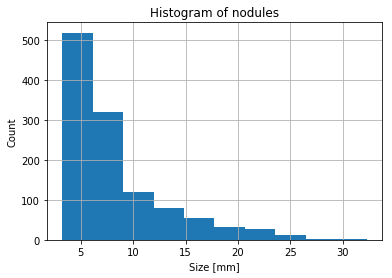

In [3]:
df = pd.read_csv(DATA_DIR+cand_path)

df['diameter_mm'].hist();
plt.title('Histogram of nodules');
plt.xlabel('Size [mm]');
plt.ylabel('Count');


In [4]:
df['diameter_mm'].describe()

count    1168.000000
mean        8.334194
std         4.774839
min         3.253443
25%         5.114802
50%         6.445805
75%         9.710238
max        32.270030
Name: diameter_mm, dtype: float64

## Image Normalization (?)

CT and Xrays can be segmented by first converting the pixel value to [Hounsfield Units](https://en.wikipedia.org/wiki/Hounsfield_scale). 

However, I am not sure we actually want to do this. Calcified nodules often turn out to be benign. So removing HU above +500 or even +3000 might not be a good idea (?) Perhaps including pixels in the bone HU range will actually help our classifier.

Substance |	Hounsfield Units (HU)
-------- | -----
Air	| −1000
Lung	| -700 to −600[2]
Fat	| −120 to −90[3]
Water	| 0
Urine	| -5 to +15[3]
Bile	| -5 to +15[3]
CSF	| +15
Kidney	|+20 to +45[3]
Liver	| 60 ± 6[5]
Lymph nodes	| +10 to +20[6]
Blood	| +30 to +45
Muscle	| +35 to +55[3]
White matter |	+20 to +30
Grey matter	| +37 to +45
Soft Tissue, Contrast	| +100 to +300
Bone	| +200 (craniofacial bone), +700 (cancellous bone) to +3000 (cortical bone)


In [5]:
"""
Normalize pixel depth into Hounsfield units (HU)

This tries to get all pixels between -1000 and 400 HU.
All other HU will be masked.

"""
def normalizePlanes(npzarray):
     
    maxHU = 400.
    minHU = -1000.
 
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

## Extract ROI image patches for candidates

Procedure:
1. Load the .mhd file for the CT image volume. This is a 3D image.
2. Load the candidates_with_annotations.csv file to specify the centers for our regions of interest (ROI).  There are usually several hundred ROIs per CT, but only between 1 and 5 of them have been labeled as true nodules by the radiologists.
3. Save a patch (32 x 32 pixel) around the center of the candidate location. Currently, they just extract a transverse (2D image at a fixed slice #). TODO: Let's think about extracting a 3D volume for our patch instead.

In [6]:
def extractCandidates(img_file):
    
    # Get the name of the file
    subjectName = ntpath.splitext(ntpath.basename(img_file))[0]  # Strip off the .mhd extension
    
    # Read the list of candidate ROI
    dfCandidates = pd.read_csv(DATA_DIR+cand_path)
    
    
    numCandidates = dfCandidates[dfCandidates['seriesuid']==subjectName].shape[0]
    print('There are {} candidate nodules in this file.'.format(numCandidates))
    
    numNonNodules = sum(dfCandidates[dfCandidates['seriesuid']==subjectName]['class'] == 0)
    numNodules = sum(dfCandidates[dfCandidates['seriesuid']==subjectName]['class'] == 1)
    print('{} are true nodules (class 1) and {} are non-nodules (class 0)'.format(numNodules, numNonNodules))
    
    # Read if the candidate ROI is a nodule (1) or non-nodule (0)
    candidateValues = dfCandidates[dfCandidates['seriesuid']==subjectName]['class'].values
    
    # Get the world coordinates (mm) of the candidate ROI center
    worldCoords = dfCandidates[dfCandidates['seriesuid']==subjectName][['coordX', 'coordY', 'coordZ']].values
    
    # Use SimpleITK to read the mhd image
    itkimage = sitk.ReadImage(DATA_DIR+img_file)
    
    # Get the real world origin (mm) for this image
    originMatrix = np.tile(itkimage.GetOrigin(), (numCandidates,1))  # Real world origin for this image (0,0)
    
    # Subtract the real world origin and scale by the real world (mm per pixel)
    # This should give us the X,Y,Z coordinates for the candidates
    candidatesPixels = (np.round(np.absolute(worldCoords - originMatrix) / itkimage.GetSpacing())).astype(int)
    
    # Replace the missing diameters with the 50th percentile diameter 
    
    
    candidateDiameter = dfCandidates['diameter_mm'].fillna(dfCandidates['diameter_mm'].quantile(0.5)).values / itkimage.GetSpacing()[1]
     
    candidatePatches = []
    
    imgAll = sitk.GetArrayFromImage(itkimage) # Read the image volume
    
    for candNum in range(numCandidates):
        
        #print('Extracting candidate patch #{}'.format(candNum))
        candidateVoxel = candidatesPixels[candNum,:]
        xpos = int(candidateVoxel[0])
        ypos = int(candidateVoxel[1])
        zpos = int(candidateVoxel[2])
        
        # Need to handle the candidates where the window would extend beyond the image boundaries
        windowSize = 32
        x_lower = np.max([0, xpos - windowSize])  # Return 0 if position off image
        x_upper = np.min([xpos + windowSize, itkimage.GetWidth()]) # Return  maxWidth if position off image
        
        y_lower = np.max([0, ypos - windowSize])  # Return 0 if position off image
        y_upper = np.min([ypos + windowSize, itkimage.GetHeight()]) # Return  maxHeight if position off image
         
        # SimpleITK is x,y,z. Numpy is z, y, x.
        imgPatch = imgAll[zpos, y_lower:y_upper, x_lower:x_upper]
        
        # Normalize to the Hounsfield units
        # TODO: I don't think we should normalize into Housefield units
        imgPatchNorm = imgPatch #normalizePlanes(imgPatch)
        
        candidatePatches.append(imgPatchNorm)  # Append the candidate image patches to a python list

    return candidatePatches, candidateValues, candidateDiameter

In [7]:
patchesArray, valuesArray, noduleDiameter = extractCandidates(img_file)

There are 1068 candidate nodules in this file.
2 are true nodules (class 1) and 1066 are non-nodules (class 0)


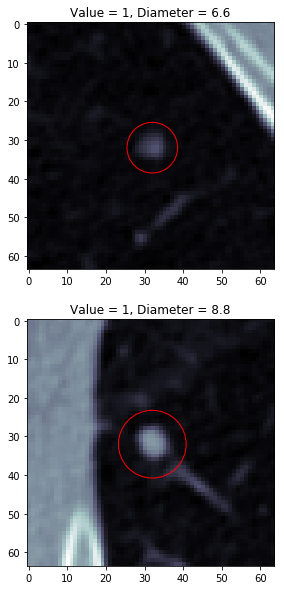

In [8]:
# Display the positive candidates (nodules)

numPositives = np.where(valuesArray==1)[0]

if (len(numPositives) > 1):
    plt.figure(figsize=(10,10))

for i, candidateNum in enumerate(numPositives):

    imgPatch = patchesArray[candidateNum]
    plt.subplot(len(numPositives),1,i+1)
    plt.imshow(imgPatch, cmap='bone');
    plt.title('Value = {}, Diameter = {:.1f}'.format(valuesArray[candidateNum], noduleDiameter[candidateNum]));
    circle = plt.Circle((imgPatch.shape[0]/2, 
                         imgPatch.shape[1]/2), 
                        radius=noduleDiameter[candidateNum], fill=False, color='r')
    plt.gca().add_patch(circle)
    

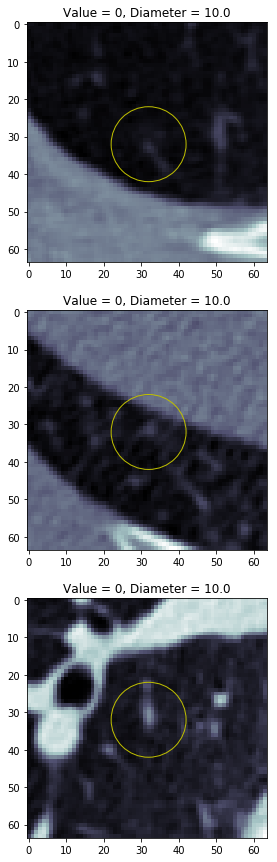

In [9]:
# Display three candidate non-nodules

numNegatives = np.where(valuesArray==0)[0]
plt.figure(figsize=(15,15))
for i, candidateNum in enumerate(numNegatives[:3]):

    imgPatch = patchesArray[candidateNum]
    plt.subplot(3,1,i+1)
    plt.imshow(imgPatch, cmap='bone');
    plt.title('Value = {}, Diameter = {:.1f}'.format(valuesArray[candidateNum], noduleDiameter[candidateNum]));
    circle = plt.Circle((imgPatch.shape[0]/2, 
                         imgPatch.shape[1]/2), 
                        radius=noduleDiameter[candidateNum], fill=False, color='y')
    plt.gca().add_patch(circle)
    